# Pulse Analysis

The objective of this analysis is to evaluate the relationship between rise time (RT) and bandwidth (BW) of a pulsated signal, going beyond the rule of tumb $BW = 0.35/RT$ [[1]](#ref_1).

## Bulding a real pulse

The initial step is to build a real pulse, that means a pulse which its rising edge has finite $dv/dt$. Getting the idea from [[2]](#ref_2) to use a error function (the integral of a gaussian) as the shape of pulse it is possible to evaluate the relation between its rise time (RT) and bandwidth (BW). 

The cumulative distribution function of a gaussian [[3]](#ref_3), $\Phi \left( \frac{x - \mu}{\sigma} \right)$, is defined as:

$\Phi \left( \frac{x - \mu}{\sigma} \right) = \frac{1}{2} \left[ 1 + erf\left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right]$

Where:

$erf\left( x \right) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}}dt$

Let's start checking the [erf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erf.html) and the [erfinv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfinv.html) functions provided by the SciPy library [[4]](#ref_4). 

In [1]:
# importing some useful libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, NullFormatter
from scipy import special
from scipy import signal
from scipy.signal import windows
from scipy.fft import fft, ifft, fftfreq

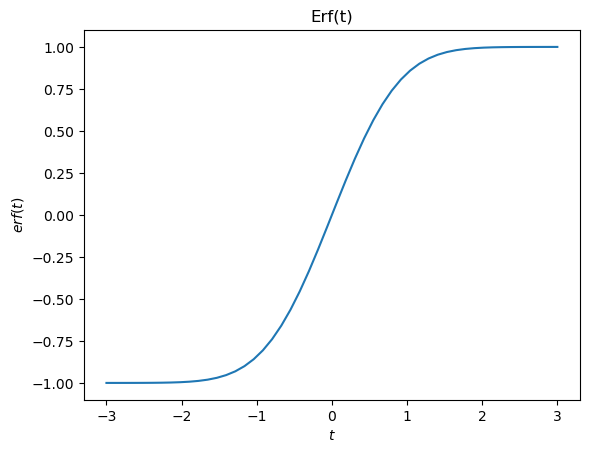

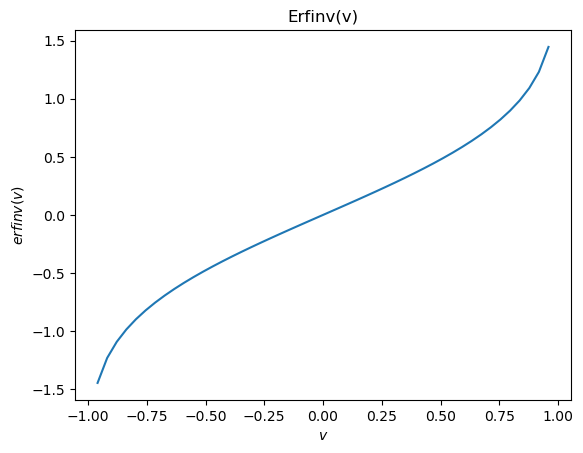

In [2]:
# visualizing the erf and erfinv
t = np.linspace(-3, 3)
plt.plot(t, special.erf(t))
plt.xlabel('$t$')
plt.ylabel('$erf(t)$')
plt.title('Erf(t)')
plt.show()

v = np.linspace(-1, 1)
plt.plot(v, special.erfinv(v))
plt.xlabel('$v$')
plt.ylabel('$erfinv(v)$')
plt.title('Erfinv(v)')
plt.show()

Now, lets define the [gaussian CDF](https://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function) (phi) to be the shape of our pulse and, its inverse (phiinv), also known as [quantile function](https://en.wikipedia.org/wiki/Normal_distribution#Quantile_function) as an auxiliary function, to calculate the rise time (10-90%) of our pulse. The pulse will be caracterized by its $\mu$ and $\sigma$, which will be tweaked to get the desired rise times.

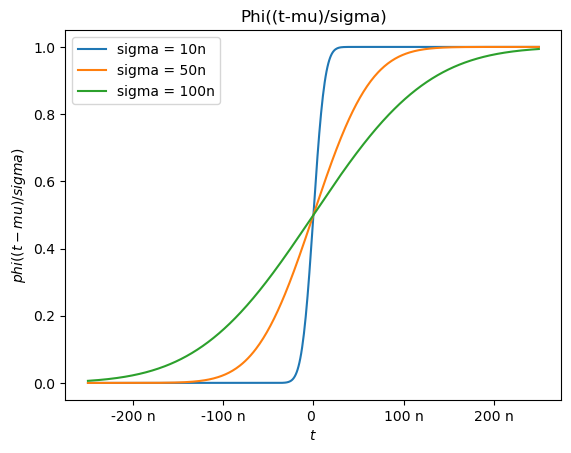

In [3]:
# using the erf to define the gaussian CDF
def phi(t, mu, sigma):
    return 1/2 * (1 + special.erf((t - mu)/(sigma * np.sqrt(2))))

t = np.linspace(-250 *10**(-9), 250 *10**(-9), num = 500)
mu = 0
sigma = 10 * 10**(-9)
sigma2 = 50 * 10**(-9)
sigma3 = 100 * 10**(-9)

plt.plot(t, phi(t, mu, sigma), label = 'sigma = 10n')
plt.plot(t, phi(t, mu, sigma2), label = 'sigma = 50n')
plt.plot(t, phi(t, mu, sigma3), label = 'sigma = 100n')

plt.xlabel('$t$')
plt.ylabel('$phi((t-mu)/sigma)$')
plt.title('Phi((t-mu)/sigma)')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

## Measuring the rise time

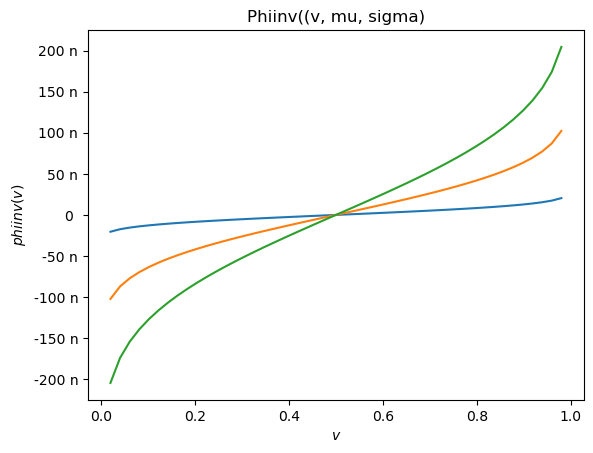

In [4]:
# using the erfinv to define the ineverse of the gaussian CDF

def phiinv(v, mu, sigma):
    return mu + sigma * (np.sqrt(2) * special.erfinv( 2 * v - 1))

v = np.linspace(0, 1)
mu = 0
sigma = 10 * 10**(-9)
sigma2 = 50 * 10**(-9)
sigma3 = 100 * 10**(-9)

plt.plot(v, phiinv(v, mu, sigma), label = 'sigma = 0.1')
plt.plot(v, phiinv(v, mu, sigma2), label = 'sigma = 0.5')
plt.plot(v, phiinv(v, mu, sigma3), label = 'sigma = 1')

plt.xlabel('$v$')
plt.ylabel('$phiinv(v)$')
plt.title('Phiinv((v, mu, sigma)')

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####

plt.show()

The rise time (10% to 90%) can be calculated by: $\phi^{-1}(0.9)-\phi^{-1}(0.1)$

In [5]:
# defining the rise time 10% to 90% function
mu = 0
sigma = 10 * 10**(-9)

def risetime_10_90(mu, sigma):
    return phiinv(0.9, mu, sigma) - phiinv(0.1, mu, sigma)
    
risetime_10_90(mu, sigma)

2.563103131089201e-08

So, lets define 3 pulses for this analysis with different rise times: 50ns, 100ns and 200ns. First, lets plot the relatioship between sigma and the risetime:

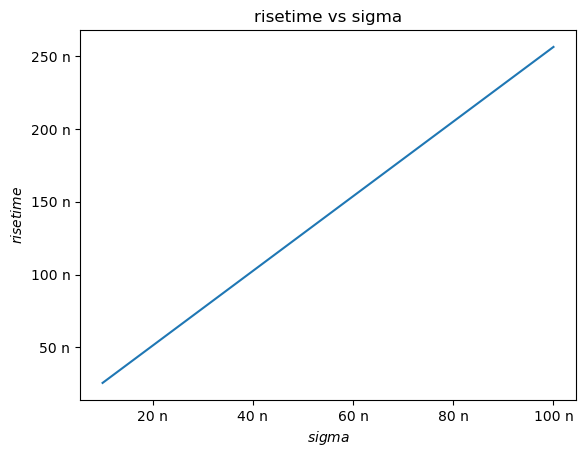

In [6]:
delta_sigma = np.linspace(10 * 10**(-9), 100 * 10**(-9), num = 5)

plt.plot(delta_sigma, risetime_10_90(0, delta_sigma))

plt.xlabel('$sigma$')
plt.ylabel('$risetime$')
plt.title('risetime vs sigma')

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####
##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

Looking the above graph and playing a bit with the ritetime_10_90 function we find the relation between RT and $\sigma$ as:

$\sigma = \dfrac{RT}{2.5631031310892}$

## Signal in the time domain

Now it is time to create ours rising_edge, pulse and train of pulses:

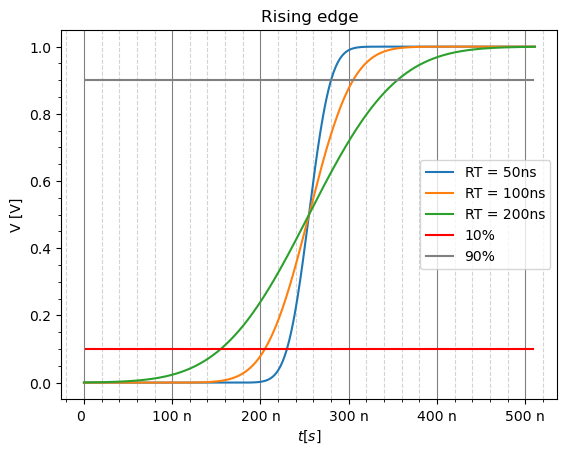

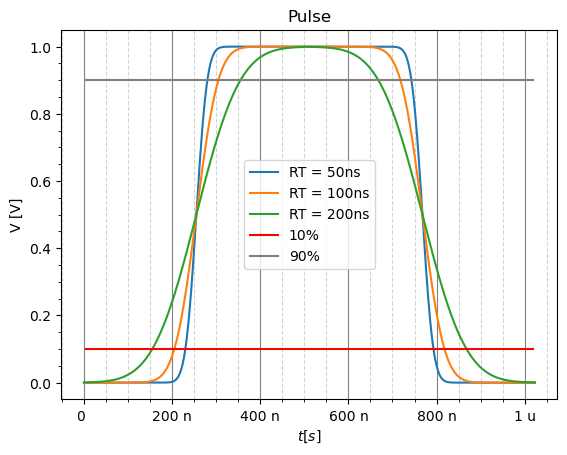

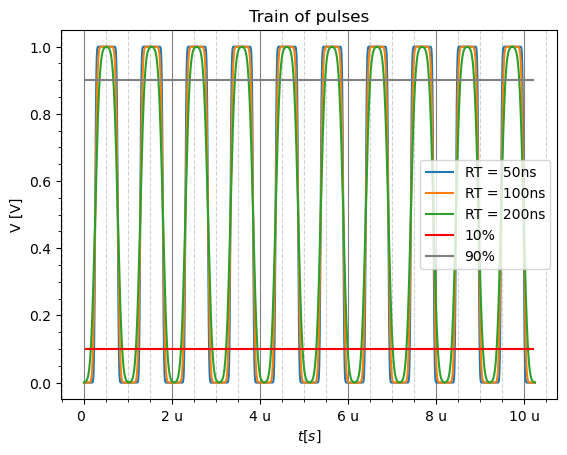

In [7]:
# create a rising edge with RT [ns] with size N and 50% transition in N/2 -1
def rising_edge(N, RT):
    sigma = (RT/2.5631031310892) *10**(-9)
    t = np.linspace(0, (N-1) *10**(-9), num = N)
    mu = (N/2 - 1) * 10**(-9) 
    return t, phi(t, mu, sigma)

N = 512 # N shall be multiple of the slower rise time, e.g. ~2.5X. And for fft purposes it shall also be base 2, e.g. 256, 512, 1024...
t, rt50 = rising_edge(N, 50)
t, rt100 = rising_edge(N, 100)
t, rt200 = rising_edge(N, 200)

plt.plot(t, rt50, label = 'RT = 50ns')
plt.plot(t, rt100, label = 'RT = 100ns')
plt.plot(t, rt200, label = 'RT = 200ns')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t [s]$')
plt.ylabel('V [V]')
plt.title('Rising edge')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()
#######################################################################################################################
# create a pulse with RT [ns] with size 2N
def pulse(N, RT):
    t, rt = rising_edge(N, RT)
    t = np.linspace(0, (2*N-1) *10**(-9), num = 2*N)
    return t, np.concatenate([rt, np.flip(rt)])

t, pulse50 = pulse (N,50)
t, pulse100 = pulse (N,100)
t, pulse200 = pulse (N,200)

plt.plot(t, pulse50, label = 'RT = 50ns')
plt.plot(t, pulse100, label = 'RT = 100ns')
plt.plot(t, pulse200, label = 'RT = 200ns')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t [s]$')
plt.ylabel('V [V]')
plt.title('Pulse')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

#######################################################################################################################
# create a train of i pulses with RT [ns] with size 2N * i
def train_pulses(N, RT, i):
    NT = 2*N*i
    t, p = pulse(N, RT)
    tp = np.copy(p)
    for x in range(i-1):
        tp = np.concatenate([tp, p])
    t = np.linspace(0, (NT - 1) *10**(-9), num = NT)
    return NT, t, tp

i = 10
NT, t, train_pulses50 = train_pulses(N, 50, i)
NT, t, train_pulses100 = train_pulses(N, 100, i)
NT, t, train_pulses200 = train_pulses(N, 200, i)

plt.plot(t, train_pulses50, label = 'RT = 50ns')
plt.plot(t, train_pulses100, label = 'RT = 100ns')
plt.plot(t, train_pulses200, label = 'RT = 200ns')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t [s]$')
plt.ylabel('V [V]')
plt.title('Train of pulses')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()


## Signal in the frequency domain

There is a common practice in the industry to use the 1st-pole rule of tumb $BW = 0.35/RT$ [[1]](#ref_1) to define the bandwidth of fast signals, particularlly to especify the the minimum bandwidth of measurements instruments such as osciloscopes and spectrum analysers [[5]](#ref_5). So, fo the 50, 100 and 200ns edge rise time signals we have:

For 50ns: $BW_{50n} = \dfrac{0.35}{50n} = 7 MHz$

For 100ns: $BW_{50n} = \dfrac{0.35}{100n} = 3.5 MHz$

For 200ns: $BW_{50n} = \dfrac{0.35}{200n} = 1.75MHz$

Once the pulses are defined and the rise times obtained, it is time to look at the spectral content of them using the [fft](https://docs.scipy.org/doc/scipy/tutorial/fft.html).

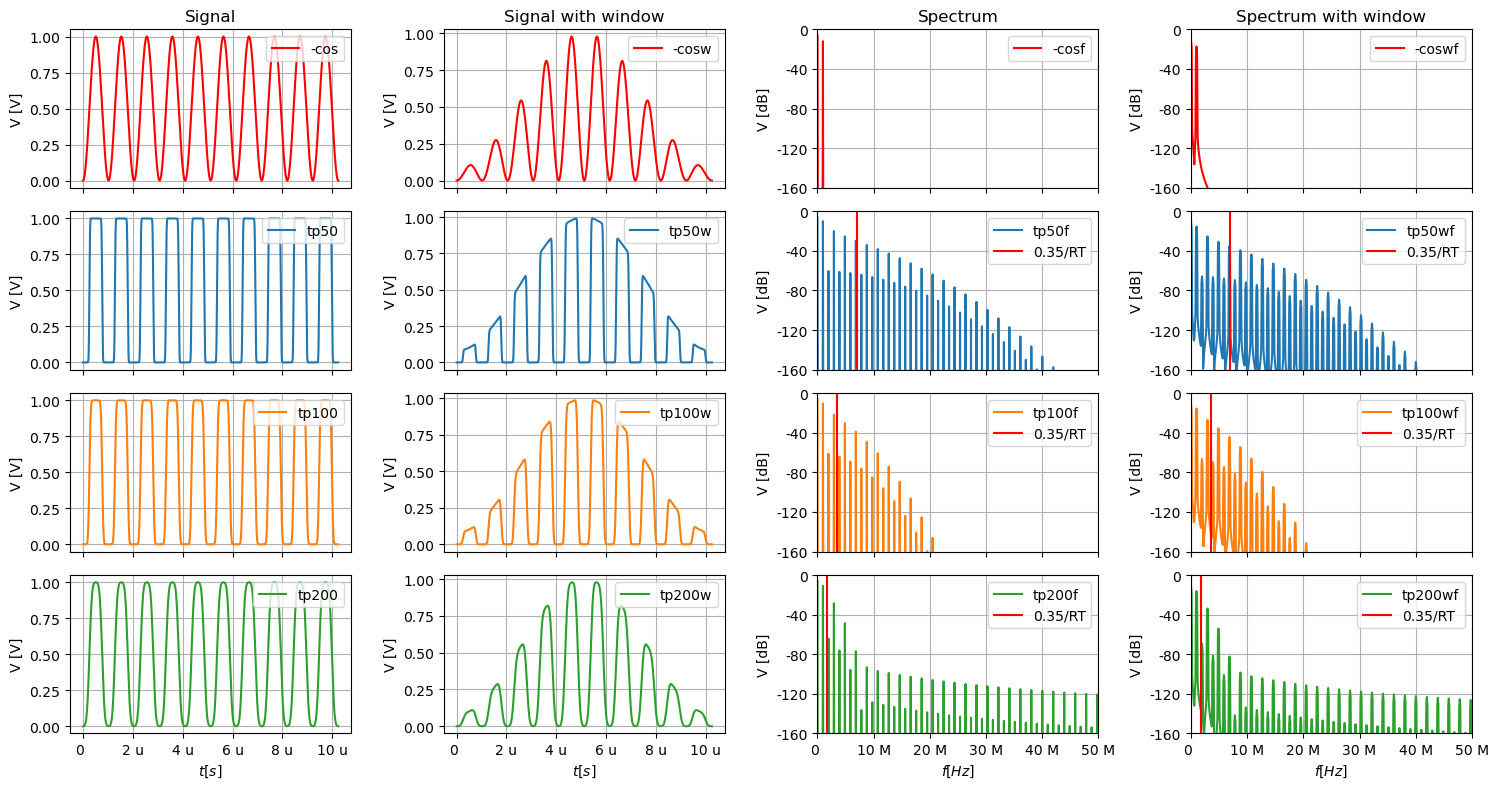

In [8]:
N = 512 # size of the rising edge segment. The pulse will be 2N long and the train of pulses will be NT = 2*N*i long
i = 10 # number of pulses in the generated train of pulses

# creating the time domain signals with 50, 100 and 200ns
NT, t, tp50 = train_pulses(N, 50, i)
NT, t, tp100 = train_pulses(N, 100, i)
NT, t, tp200 = train_pulses(N, 200, i)

# defining the frequency axis scale
xf = fftfreq(NT, d = 10**(-9))

# applying the fft in the signals
tp50f = fft(tp50, norm = 'forward')
tp100f = fft(tp100, norm = 'forward')
tp200f = fft(tp200, norm = 'forward')

# using a window function to compare the results
w = windows.hamming(NT)

# applying the window function
tp50w = tp50*w
tp100w = tp100*w
tp200w = tp200*w

# applying the fft in the "windowed" signal
tp50wf = fft(tp50w, norm = 'forward')
tp100wf = fft(tp100w, norm = 'forward')
tp200wf = fft(tp200w, norm = 'forward')

### sanity check
# creating a known signal to be sure no "distortion" is present in the fft
f = (1000/(2*N))*10**6
s = -0.5*np.cos(2*np.pi*f*t)+0.5# + 2*np.sin(2*np.pi*10*f*t)
sw = s*w
sf = np.abs(fft(s, norm = 'forward'))
sfw = np.abs(fft(sw, norm = 'forward'))
### end sanity check

zoom = 2 # auxiliary variable to help "zooming" in the frequency axis

#plotting the data
fig, axs = plt.subplots(nrows = 4, ncols = 4, sharex = 'col', sharey = False)

### sanity check
axs[0,0].plot(t, s, '-r', label = '-cos')
axs[0,1].plot(t, sw, '-r', label = '-cosw')
axs[0,2].semilogy(xf[0:NT//zoom], sf[0:NT//zoom], '-r', label = '-cosf')
axs[0,3].semilogy(xf[0:NT//zoom], sfw[0:NT//zoom], '-r', label = '-coswf')
### end sanity check

axs[1,0].plot(t, tp50, label = 'tp50', color = 'tab:blue')
axs[1,1].plot(t, tp50w, label = 'tp50w', color = 'tab:blue')
axs[1,2].semilogy(xf[0:NT//zoom], np.abs(tp50f)[0:NT//zoom], label = 'tp50f', color = 'tab:blue') # [0:N//2] -> plotting just the 1st half of the fft which represents the positive values
axs[1,3].semilogy(xf[0:NT//zoom], np.abs(tp50wf)[0:NT//zoom], label = 'tp50wf', color = 'tab:blue')
axs[2,0].plot(t, tp100, label = 'tp100', color = 'tab:orange')
axs[2,1].plot(t, tp100w, label = 'tp100w', color = 'tab:orange')
axs[2,2].semilogy(xf[0:NT//zoom], np.abs(tp100f)[0:NT//zoom], label = 'tp100f', color = 'tab:orange')
axs[2,3].semilogy(xf[0:NT//zoom], np.abs(tp100wf)[0:NT//zoom], label = 'tp100wf', color = 'tab:orange')
axs[3,0].plot(t, tp200, label = 'tp200', color = 'tab:green')
axs[3,1].plot(t, tp200w, label = 'tp200w', color = 'tab:green')
axs[3,2].semilogy(xf[0:NT//zoom], np.abs(tp200f)[0:NT//zoom], label = 'tp200f', color = 'tab:green')
axs[3,3].semilogy(xf[0:NT//zoom], np.abs(tp200wf)[0:NT//zoom], label = 'tp200wf', color = 'tab:green')

#adding the 0.35/RT bandwidth as a vertical red line in the plots
axs[1,2].axvline(7 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[1,3].axvline(7 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[2,2].axvline(3.5 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[2,3].axvline(3.5 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[3,2].axvline(1.75 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[3,3].axvline(1.75 *10**6, 0, 1, color = 'red', label = '0.35/RT')

axs[3,0].set_xlabel('$t [s]$')
axs[3,1].set_xlabel('$t [s]$')
axs[3,2].set_xlabel('$f [Hz]$')
axs[3,3].set_xlabel('$f [Hz]$')
axs[0,0].set_ylabel('V [V]')
axs[1,0].set_ylabel('V [V]')
axs[2,0].set_ylabel('V [V]')
axs[3,0].set_ylabel('V [V]')
axs[0,1].set_ylabel('V [V]')
axs[1,1].set_ylabel('V [V]')
axs[2,1].set_ylabel('V [V]')
axs[3,1].set_ylabel('V [V]')
axs[0,2].set_ylabel('V [dB]')
axs[1,2].set_ylabel('V [dB]')
axs[2,2].set_ylabel('V [dB]')
axs[3,2].set_ylabel('V [dB]')
axs[0,3].set_ylabel('V [dB]')
axs[1,3].set_ylabel('V [dB]')
axs[2,3].set_ylabel('V [dB]')
axs[3,3].set_ylabel('V [dB]')
axs[0,0].set_title('Signal')
axs[0,1].set_title('Signal with window')
axs[0,2].set_title('Spectrum')
axs[0,3].set_title('Spectrum with window')

axs[0,0].legend(loc="upper right")
axs[0,1].legend(loc="upper right")
axs[0,2].legend(loc="upper right")
axs[0,3].legend(loc="upper right")
axs[1,0].legend(loc="upper right")
axs[1,1].legend(loc="upper right")
axs[1,2].legend(loc="upper right")
axs[1,3].legend(loc="upper right")
axs[2,0].legend(loc="upper right")
axs[2,1].legend(loc="upper right")
axs[2,2].legend(loc="upper right")
axs[2,3].legend(loc="upper right")
axs[3,0].legend(loc="upper right")
axs[3,1].legend(loc="upper right")
axs[3,2].legend(loc="upper right")
axs[3,3].legend(loc="upper right")

axs[0,0].grid(True)
axs[0,1].grid(True)
axs[0,2].grid(True)
axs[0,3].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
axs[1,2].grid(True)
axs[1,3].grid(True)
axs[2,0].grid(True)
axs[2,1].grid(True)
axs[2,2].grid(True)
axs[2,3].grid(True)
axs[3,0].grid(True)
axs[3,1].grid(True)
axs[3,2].grid(True)
axs[3,3].grid(True)

axs[3,2].set_xlim([0, 50 *10**6])
axs[3,3].set_xlim([0, 50 *10**6])

axs[0,2].set_ylim([10**-8, 1])
axs[0,3].set_ylim([10**-8, 1])
axs[1,2].set_ylim([10**-8, 1])
axs[1,3].set_ylim([10**-8, 1])
axs[2,2].set_ylim([10**-8, 1])
axs[2,3].set_ylim([10**-8, 1])
axs[3,2].set_ylim([10**-8, 1])
axs[3,3].set_ylim([10**-8, 1])

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    scaled_value = 20*np.log10(value)
    return f'{scaled_value:g}'
# Apply the formatter to y-axis ticks
axs[0,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[0,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[1,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[1,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[2,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[2,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[3,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[3,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####
##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
axs[3,0].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
axs[3,1].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
axs[3,2].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
axs[3,3].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

fig.set_figheight(8)
fig.set_figwidth(15)
fig.tight_layout()

plt.show()

## Power spectral density analisys

As the cutoff frequency of a filter is defined as the frequency where the filter attenuate a portion of the signals' power, commonly 50% of its power, also known as $f_{c}$ or $f_{3dB}$ [[6]](#ref_6). To understand better the meaning of the bandwidth of a signal and the possible effects that happen to the signal when it passes through a band-limited system (like a filter or transmission line), it is interesting to look at the spectrum from the point of view of the Power Spectral Density (PSD). So it is possible to look what happens when other cutoff frequencies are defined (e.g. 90%, 95%, 99% of its power, and so on). There are a few ways to estimate the PSD of signal and Welch's method is considered a good one [[7]](#ref_7). It can be easily obtained using SciPy implemetation [[8]](#ref_8).

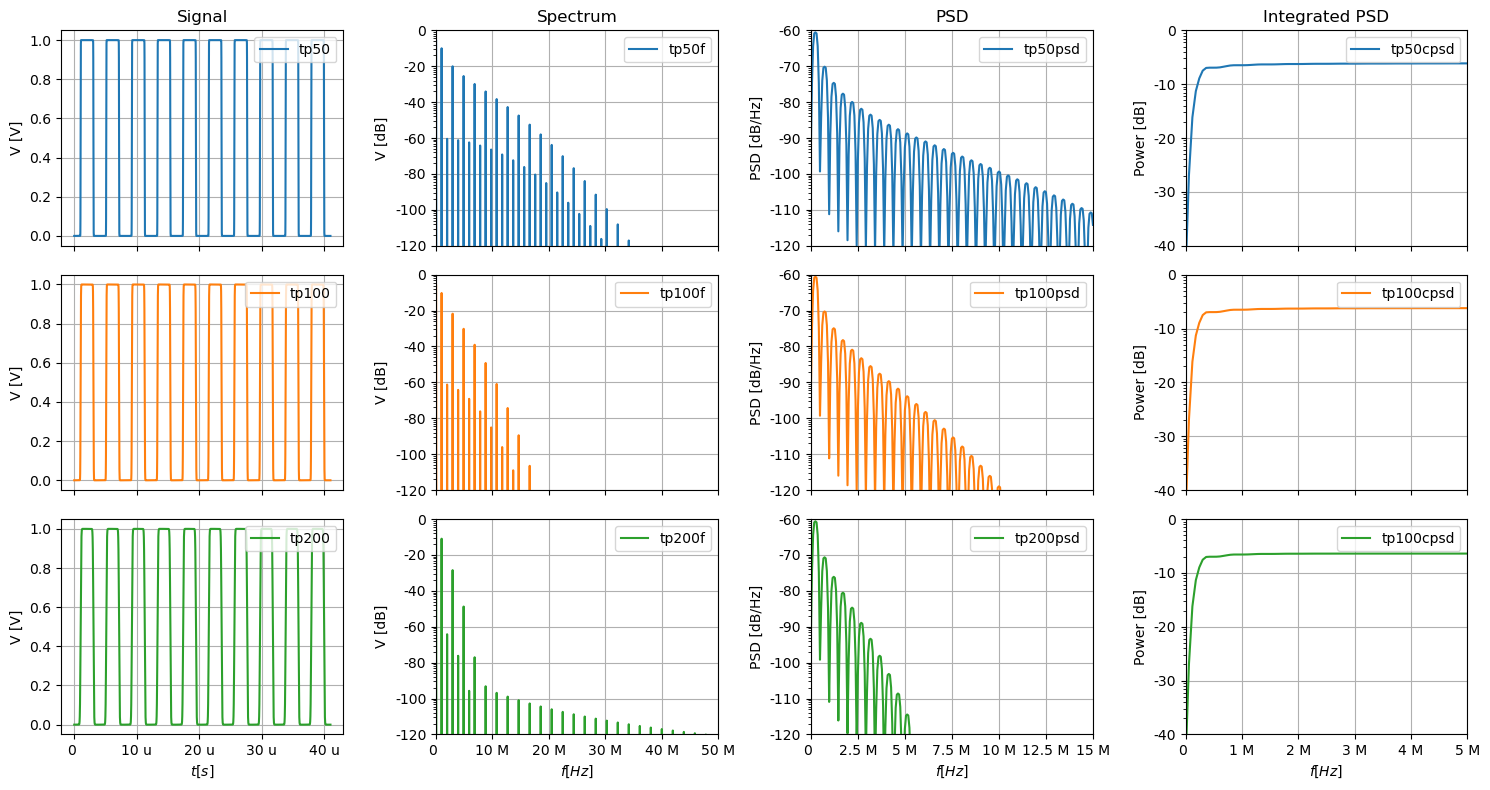

In [9]:
N = 2048 # size of the rising edge segment. The pulse will be 2N long and the train of pulses will be NT = 2*N*i long
i = 10 # number of pulses in the generated train of pulses
fs = 10**9 # sampling frequency, input parameter for welch's function
w_seg = 16*1024 # segmant size , input parameter for welch's function

# creating the time domain signals with 50, 100 and 200ns
NT, t, tp50 = train_pulses(N, 50, i)
NT, t, tp100 = train_pulses(N, 100, i)
NT, t, tp200 = train_pulses(N, 200, i)

# obtaining the PSDs
f, PSD50 = signal.welch(tp50, fs, 'flattop', nperseg=w_seg)
f2, PSD100 = signal.welch(tp100, fs, 'flattop', nperseg=w_seg)
f3, PSD200 = signal.welch(tp200, fs, 'flattop', nperseg=w_seg)

# Integrate the PSDs to obtain the cumulative power
cum_power50 = np.cumsum(PSD50) * (f[1] - f[0])
cum_power100 = np.cumsum(PSD100) * (f2[1] - f2[0])
cum_power200 = np.cumsum(PSD200) * (f3[1] - f3[0])

#plotting the data
fig, axs = plt.subplots(nrows = 3, ncols = 4, sharex = 'col', sharey = False)

axs[0,0].plot(t, tp50, label = 'tp50', color = 'tab:blue')
axs[0,1].semilogy(xf[0:NT//zoom], np.abs(tp50f)[0:NT//zoom], label = 'tp50f', color = 'tab:blue')
axs[0,2].semilogy(f[0:NT//zoom], PSD50, label = 'tp50psd', color = 'tab:blue') # [0:N//2] -> plotting just the 1st half of the fft which represents the positive values
axs[0,3].semilogy(f[0:NT//zoom], cum_power50, label = 'tp50cpsd', color = 'tab:blue')

axs[1,0].plot(t, tp100, label = 'tp100', color = 'tab:orange')
axs[1,1].semilogy(xf[0:NT//zoom], np.abs(tp100f)[0:NT//zoom], label = 'tp100f', color = 'tab:orange')
axs[1,2].semilogy(f2[0:NT//zoom], PSD100, label = 'tp100psd', color = 'tab:orange')
axs[1,3].semilogy(f2[0:NT//zoom], cum_power100, label = 'tp100cpsd', color = 'tab:orange')

axs[2,0].plot(t, tp200, label = 'tp200', color = 'tab:green')
axs[2,1].semilogy(xf[0:NT//zoom], np.abs(tp200f)[0:NT//zoom], label = 'tp200f', color = 'tab:green')
axs[2,2].semilogy(f3[0:NT//zoom], PSD200, label = 'tp200psd', color = 'tab:green')
axs[2,3].semilogy(f3[0:NT//zoom], cum_power200, label = 'tp100cpsd', color = 'tab:green')

axs[2,0].set_xlabel('$t [s]$')
axs[2,1].set_xlabel('$f [Hz]$')
axs[2,2].set_xlabel('$f [Hz]$')
axs[2,3].set_xlabel('$f [Hz]$')

axs[0,0].set_ylabel('V [V]')
axs[1,0].set_ylabel('V [V]')
axs[2,0].set_ylabel('V [V]')

axs[0,1].set_ylabel('V [dB]')
axs[1,1].set_ylabel('V [dB]')
axs[2,1].set_ylabel('V [dB]')

axs[0,2].set_ylabel('PSD [dB/Hz]')
axs[1,2].set_ylabel('PSD [dB/Hz]')
axs[2,2].set_ylabel('PSD [dB/Hz]')

axs[0,3].set_ylabel('Power [dB]')
axs[1,3].set_ylabel('Power [dB]')
axs[2,3].set_ylabel('Power [dB]')

axs[0,0].set_title('Signal')
axs[0,1].set_title('Spectrum')
axs[0,2].set_title('PSD')
axs[0,3].set_title('Integrated PSD')

axs[0,0].legend(loc="upper right")
axs[0,1].legend(loc="upper right")
axs[0,2].legend(loc="upper right")
axs[0,3].legend(loc="upper right")
axs[1,0].legend(loc="upper right")
axs[1,1].legend(loc="upper right")
axs[1,2].legend(loc="upper right")
axs[1,3].legend(loc="upper right")
axs[2,0].legend(loc="upper right")
axs[2,1].legend(loc="upper right")
axs[2,2].legend(loc="upper right")
axs[2,3].legend(loc="upper right")

axs[0,0].grid(True)
axs[0,1].grid(True)
axs[0,2].grid(True)
axs[0,3].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
axs[1,2].grid(True)
axs[1,3].grid(True)
axs[2,0].grid(True)
axs[2,1].grid(True)
axs[2,2].grid(True)
axs[2,3].grid(True)

axs[2,1].set_xlim([0, 50 *10**6])
axs[2,2].set_xlim([0, 15 *10**6])
axs[2,3].set_xlim([0, 5 *10**6])

axs[0,1].set_ylim([10**-6, 1])
axs[0,2].set_ylim([10**-12, 10**-6])
axs[0,3].set_ylim([10**-4, 1])
axs[1,1].set_ylim([10**-6, 1])
axs[1,2].set_ylim([10**-12, 10**-6])
axs[1,3].set_ylim([10**-4, 1])
axs[2,1].set_ylim([10**-6, 1])
axs[2,2].set_ylim([10**-12, 10**-6])
axs[2,3].set_ylim([10**-4, 1])

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    scaled_value = 20*np.log10(value) #20log for voltage
    return f'{scaled_value:g}'
# Apply the formatter to y-axis ticks
axs[0,1].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[1,1].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[2,1].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    scaled_value = 10*np.log10(value) #10log for power
    return f'{scaled_value:g}'
# Apply the formatter to y-axis ticks
axs[0,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[1,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[2,2].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

axs[0,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[1,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
axs[2,3].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
axs[2,0].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
axs[2,1].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
axs[2,2].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
axs[2,3].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

fig.set_figheight(8)
fig.set_figwidth(15)
fig.tight_layout()

plt.show()

From the cumulative PSD calculation we obtain the total signal power as the last value of the cumulative vector:

In [10]:
cum_power50[-1]

0.24469247896100202

In [11]:
cum_power100[-1]

0.23931731457195396

In [12]:
cum_power200[-1]

0.2285667878855947

Then, we normalize the cumulative PSD vectors with the total power:

In [13]:
cum_power50p = cum_power50 / cum_power50[-1]
cum_power50p[:140]

array([1.13958938e-04, 8.36050016e-03, 9.91137895e-02, 3.04032878e-01,
       5.23495953e-01, 7.28478021e-01, 8.19370390e-01, 8.27680026e-01,
       8.27709187e-01, 8.28598129e-01, 8.38563679e-01, 8.61148923e-01,
       8.85358926e-01, 9.07985890e-01, 9.18043545e-01, 9.18974206e-01,
       9.18976084e-01, 9.19286654e-01, 9.22812244e-01, 9.30822227e-01,
       9.39413760e-01, 9.47448420e-01, 9.51028486e-01, 9.51363730e-01,
       9.51364357e-01, 9.51517006e-01, 9.53272032e-01, 9.57269322e-01,
       9.61559492e-01, 9.65574033e-01, 9.67367143e-01, 9.67537040e-01,
       9.67537395e-01, 9.67625704e-01, 9.68654152e-01, 9.71002446e-01,
       9.73524371e-01, 9.75885704e-01, 9.76942936e-01, 9.77044279e-01,
       9.77044532e-01, 9.77100650e-01, 9.77762790e-01, 9.79278492e-01,
       9.80907282e-01, 9.82433276e-01, 9.83118136e-01, 9.83184543e-01,
       9.83184745e-01, 9.83222607e-01, 9.83675292e-01, 9.84714158e-01,
       9.85831237e-01, 9.86878445e-01, 9.87349546e-01, 9.87395746e-01,
      

In [14]:
cum_power100p = cum_power100 / cum_power100[-1]
cum_power100p[:80]

array([1.16205908e-04, 8.52534721e-03, 1.01068052e-01, 3.10027606e-01,
       5.33817893e-01, 7.42841409e-01, 8.35525366e-01, 8.43998586e-01,
       8.44028603e-01, 8.44915660e-01, 8.54861330e-01, 8.77402083e-01,
       9.01564517e-01, 9.24146855e-01, 9.34184330e-01, 9.35112966e-01,
       9.35114920e-01, 9.35411697e-01, 9.38782011e-01, 9.46439791e-01,
       9.54653676e-01, 9.62335018e-01, 9.65757350e-01, 9.66077683e-01,
       9.66078326e-01, 9.66215020e-01, 9.67787842e-01, 9.71370687e-01,
       9.75216168e-01, 9.78814460e-01, 9.80421379e-01, 9.80573509e-01,
       9.80573857e-01, 9.80646372e-01, 9.81492015e-01, 9.83423403e-01,
       9.85497708e-01, 9.87439811e-01, 9.88309105e-01, 9.88392323e-01,
       9.88392552e-01, 9.88433903e-01, 9.88922796e-01, 9.90042360e-01,
       9.91245554e-01, 9.92372716e-01, 9.92878379e-01, 9.92927316e-01,
       9.92927481e-01, 9.92951978e-01, 9.93245723e-01, 9.93920214e-01,
       9.94645569e-01, 9.95325476e-01, 9.95631171e-01, 9.95661071e-01,
      

In [15]:
cum_power200p = cum_power200 / cum_power200[-1]
cum_power200p[:50]

array([1.20371166e-04, 8.83092782e-03, 1.04690713e-01, 3.21140165e-01,
       5.52951849e-01, 7.69466497e-01, 8.65470256e-01, 8.74246126e-01,
       8.74278359e-01, 8.75120985e-01, 8.84573327e-01, 9.05998176e-01,
       9.28964897e-01, 9.50429094e-01, 9.59968299e-01, 9.60850255e-01,
       9.60852407e-01, 9.61089474e-01, 9.63785938e-01, 9.69914545e-01,
       9.76488633e-01, 9.82636042e-01, 9.85374007e-01, 9.85629852e-01,
       9.85630505e-01, 9.85714697e-01, 9.86686601e-01, 9.88901988e-01,
       9.91280089e-01, 9.93505021e-01, 9.94497989e-01, 9.94591702e-01,
       9.94591988e-01, 9.94623562e-01, 9.94993856e-01, 9.95840510e-01,
       9.96750024e-01, 9.97601388e-01, 9.97982070e-01, 9.98018332e-01,
       9.98018469e-01, 9.98030137e-01, 9.98169319e-01, 9.98488585e-01,
       9.98831822e-01, 9.99153268e-01, 9.99297259e-01, 9.99311095e-01,
       9.99311158e-01, 9.99315265e-01])

In [16]:
f[:140]

array([      0.     ,   61035.15625,  122070.3125 ,  183105.46875,
        244140.625  ,  305175.78125,  366210.9375 ,  427246.09375,
        488281.25   ,  549316.40625,  610351.5625 ,  671386.71875,
        732421.875  ,  793457.03125,  854492.1875 ,  915527.34375,
        976562.5    , 1037597.65625, 1098632.8125 , 1159667.96875,
       1220703.125  , 1281738.28125, 1342773.4375 , 1403808.59375,
       1464843.75   , 1525878.90625, 1586914.0625 , 1647949.21875,
       1708984.375  , 1770019.53125, 1831054.6875 , 1892089.84375,
       1953125.     , 2014160.15625, 2075195.3125 , 2136230.46875,
       2197265.625  , 2258300.78125, 2319335.9375 , 2380371.09375,
       2441406.25   , 2502441.40625, 2563476.5625 , 2624511.71875,
       2685546.875  , 2746582.03125, 2807617.1875 , 2868652.34375,
       2929687.5    , 2990722.65625, 3051757.8125 , 3112792.96875,
       3173828.125  , 3234863.28125, 3295898.4375 , 3356933.59375,
       3417968.75   , 3479003.90625, 3540039.0625 , 3601074.21

From the cumulative PSD vectors we can obtain some cutoff fequencies as:

In [17]:
f_50p_50n = f[np.where(cum_power50p >= 0.5)[0][0]]
f_90p_50n = f[np.where(cum_power50p >= 0.9)[0][0]]
f_95p_50n = f[np.where(cum_power50p >= 0.95)[0][0]]
f_99p_50n = f[np.where(cum_power50p >= 0.99)[0][0]]
f_99_9p_50n = f[np.where(cum_power50p >= 0.999)[0][0]]

f_50p_100n = f[np.where(cum_power100p >= 0.5)[0][0]]
f_90p_100n = f[np.where(cum_power100p >= 0.9)[0][0]]
f_95p_100n = f[np.where(cum_power100p >= 0.95)[0][0]]
f_99p_100n = f[np.where(cum_power100p >= 0.99)[0][0]]
f_99_9p_100n = f[np.where(cum_power100p >= 0.999)[0][0]]

f_50p_200n = f[np.where(cum_power200p >= 0.5)[0][0]]
f_90p_200n = f[np.where(cum_power200p >= 0.9)[0][0]]
f_95p_200n = f[np.where(cum_power200p >= 0.95)[0][0]]
f_99p_200n = f[np.where(cum_power200p >= 0.99)[0][0]]
f_99_9p_200n = f[np.where(cum_power200p >= 0.999)[0][0]]

print('50n:', f_50p_50n, ' , ', f_90p_50n, ' , ',  f_95p_50n, ' , ',  f_99p_50n, ' , ',  f_99_9p_50n)
print('100n:', f_50p_200n, ' , ', f_90p_100n, ' , ',  f_95p_100n, ' , ',  f_99p_100n, ' , ',  f_99_9p_100n)
print('200n:', f_50p_200n, ' , ', f_90p_200n, ' , ',  f_95p_200n, ' , ',  f_99p_200n, ' , ',  f_99_9p_200n)

50n: 244140.62499999997  ,  793457.0312499999  ,  1342773.4374999998  ,  3723144.5312499995  ,  8422851.562499998
100n: 244140.62499999997  ,  732421.8749999999  ,  1220703.1249999998  ,  2624511.7187499995  ,  4760742.187499999
200n: 244140.62499999997  ,  671386.7187499999  ,  793457.0312499999  ,  1708984.3749999998  ,  2746582.0312499995


From the cumulative PSDs we can check what is the amount o power contained in the bandwidth defined by $BW = 0.35/RT$:

In [18]:
cum_power50p[np.where(f >= 7 *10**6)[0][0]]

0.998028444395362

In [19]:
cum_power100p[np.where(f >= 3.5 *10**6)[0][0]]

0.9958558955159119

In [20]:
cum_power200p[np.where(f >= 1.75 *10**6)[0][0]]

0.993505021451059

Plotting everything to make more visual:

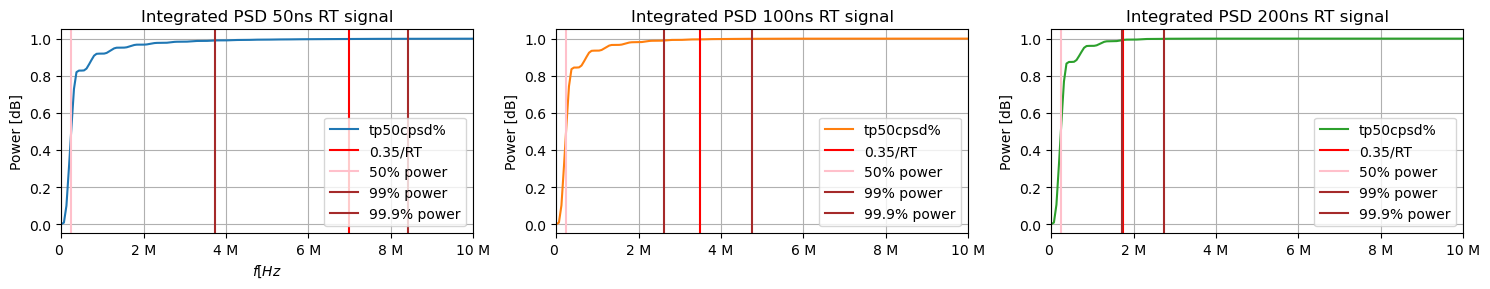

In [21]:
cum_power50p = cum_power50 / cum_power50[-1]
cum_power100p = cum_power100 / cum_power100[-1]
cum_power200p = cum_power200 / cum_power200[-1]

#plotting the data
fig, axs = plt.subplots(nrows = 1, ncols = 3, sharex = 'all', sharey = False)

axs[0].plot(f, cum_power50p, label = 'tp50cpsd%', color = 'tab:blue')
axs[1].plot(f, cum_power100p, label = 'tp50cpsd%', color = 'tab:orange')
axs[2].plot(f, cum_power200p, label = 'tp50cpsd%', color = 'tab:green')

#adding the 0.35/RT bandwidth as a vertical red line in the plots
axs[0].axvline(7 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[1].axvline(3.5 *10**6, 0, 1, color = 'red', label = '0.35/RT')
axs[2].axvline(1.75 *10**6, 0, 1, color = 'red', label = '0.35/RT')

#adding the 50% power bandwidth as a vertical pink line in the plots
axs[0].axvline(f_50p_50n, 0, 1, color = 'pink', label = '50% power')
axs[1].axvline(f_50p_100n, 0, 1, color = 'pink', label = '50% power')
axs[2].axvline(f_50p_200n, 0, 1, color = 'pink', label = '50% power')

#adding the 99% power bandwidth as a vertical brown line in the plots
axs[0].axvline(f_99p_50n, 0, 1, color = 'brown', label = '99% power')
axs[1].axvline(f_99p_100n, 0, 1, color = 'brown', label = '99% power')
axs[2].axvline(f_99p_200n, 0, 1, color = 'brown', label = '99% power')

#adding the 99.9% power bandwidth as a vertical purple line in the plots
axs[0].axvline(f_99_9p_50n, 0, 1, color = 'brown', label = '99.9% power')
axs[1].axvline(f_99_9p_100n, 0, 1, color = 'brown', label = '99.9% power')
axs[2].axvline(f_99_9p_200n, 0, 1, color = 'brown', label = '99.9% power')

axs[0].set_xlabel('$f [Hz$')

axs[0].set_ylabel('Power [dB]')
axs[1].set_ylabel('Power [dB]')
axs[2].set_ylabel('Power [dB]')

axs[0].set_title('Integrated PSD 50ns RT signal')
axs[1].set_title('Integrated PSD 100ns RT signal')
axs[2].set_title('Integrated PSD 200ns RT signal')

axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
axs[2].legend(loc="lower right")

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

axs[0].set_xlim([0, 10 *10**6])

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
axs[0].xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

fig.set_figheight(3)
fig.set_figwidth(15)
fig.tight_layout()

plt.show()

## References

<a id="ref_1"></a>
[1] Back to Basics: Bandwidth and Rise Time - https://www.signalintegrityjournal.com/blogs/12-fundamentals/post/853-back-to-basics-bandwidth-and-rise-time

<a id="ref_2"></a>
[2] Bandwidth of Signals: What is Important, Rise Time or Slew Rate? - https://www.signalintegrityjournal.com/articles/2092-bandwidth-of-signals-what-is-important-rise-time-or-slew-rate?page=2

<a id='ref_3'></a>
[3] Normal distribution - https://en.wikipedia.org/wiki/Normal_distribution

<a id='ref_4'></a>
[4] SciPy documentation - https://docs.scipy.org/doc/scipy/index.html

<a id='ref_5'></a>
[5] Evaluating Oscilloscope Bandwidths for Your Application - https://www.keysight.com/us/en/assets/7018-01455/application-notes/5989-5733.pdf

<a id='ref_6'></a>
[6] Cutoff frequency - https://en.wikipedia.org/wiki/Cutoff_frequency

<a id='ref_7'></a>
[7] Welch's method - https://en.wikipedia.org/wiki/Welch%27s_method

<a id='ref_8'></a>
[8] scipy.signal.welch - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html